In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json

In [2]:
run_start = 1
run_number = 3
raw_runs = []
resource_dfs = []
method = 'Trigger'
for i in range(run_start, run_start + run_number):
    with open(f"data/stress_{i}.json", "r") as f:
        raw_runs.append([json.loads(line) for line in f])
        resource_dfs.append(pd.read_csv(f"data/stress_cpu_memory_{i}.csv", parse_dates=['timestamp']))

In [3]:
def prepare_dataframe(data):
    df = pd.json_normalize(data)

    df['timestamp'] = pd.to_datetime(df['data.time']).dt.floor('S')
    df['value'] = pd.to_numeric(df['data.value'])
    df = df[['timestamp', 'metric', 'value']].sort_values('timestamp')

    # df with only the columns needed and the timestamp as the index
    df = (df.pivot_table(index='timestamp', columns='metric', values='value', aggfunc='sum').fillna(0))

    t0 = df.index.min()
    t1 = df.index.max()

    # index in seconds instead of timestamps
    index_in_seconds = (df.index - t0).total_seconds().astype(int)
    df.index = index_in_seconds

    # fill up missing seconds (should not be needed but just in case)
    full_idx = pd.RangeIndex(start=0, stop=int((t1 - t0).total_seconds()) + 1, step=1, name='t_seconds')
    df = df.reindex(full_idx, fill_value=0)

    df['connections'] = df['single_client_connections'].cumsum()

    return df, t0

In [4]:
def load_resource_data(df, base_time):
    df['cpu'] = df['cpu_percent'].str.replace('%', '', regex=False).astype(float)
    df['mem'] = df['memory_usage'].str.extract(r'([\d\.]+)MiB').astype(float)
    df['t_seconds'] = (df['timestamp'].dt.floor('S') - base_time).dt.total_seconds().astype(int)
    df = df.groupby('t_seconds')[['cpu', 'mem']].mean().sort_index()
    full_idx = pd.RangeIndex(start=0, stop=df.index.max() + 1, step=1, name='t_seconds')
    df = df.reindex(full_idx).ffill().fillna(0)

    df = df.rolling(window=5, min_periods=1).mean()

    return df

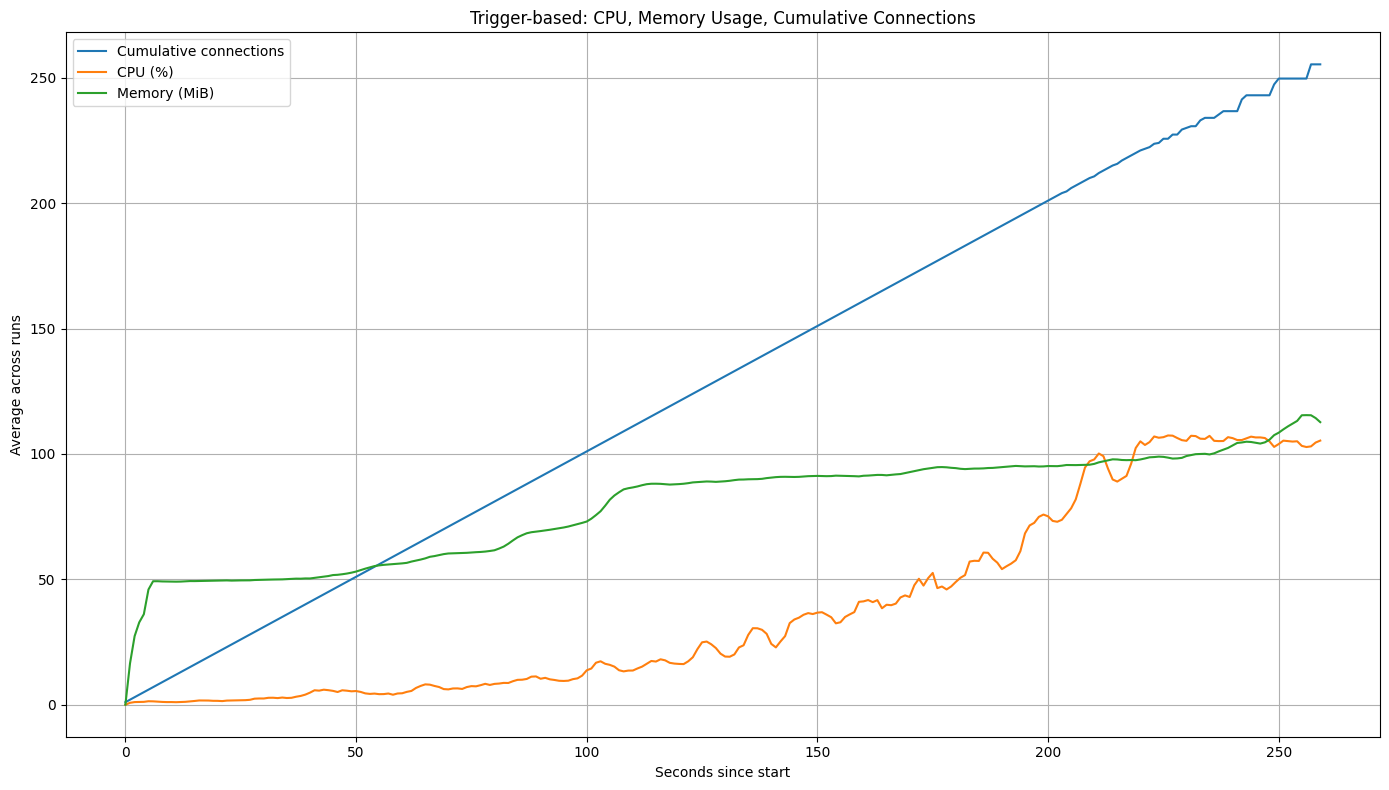

In [ ]:
plt.figure(figsize=(14, 8))

runs = []
runs_resource = []

increase_points = []
for i in range(len(raw_runs)):
    s, run_t0 = prepare_dataframe(raw_runs[i])
    resource_df = load_resource_data(resource_dfs[i], run_t0)

    runs.append(s[['connections']].sort_index())
    runs_resource.append(resource_df)

comb = pd.concat(runs, axis=1, keys=range(1, len(runs) + 1))
cpu_mem = pd.concat(runs_resource, axis=1, keys=range(1, len(runs_resource) + 1))

avg_conn = comb.xs('connections', axis=1, level=1).mean(axis=1)
avg_cpu = cpu_mem.xs('cpu', axis=1, level=1).mean(axis=1)
avg_mem = cpu_mem.xs('mem', axis=1, level=1).mean(axis=1)

plt.plot(avg_conn.index, avg_conn.values, label=f'Cumulative connections')
plt.plot(avg_cpu.index, avg_cpu.values, label='CPU (%)')
plt.plot(avg_mem.index, avg_mem.values, label='Memory (MiB)')


plt.xlabel("Seconds since start")
plt.ylabel("Average across runs")
plt.title(f'{method}-based: CPU, Memory Usage, Cumulative Connections')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()